

#Setup

In [2]:
import numpy as np

FIG_SIZE = (9,4)
FIG_SIZE_2ROWS = (9,6)

NUM_STEPS = 100
FORECAST_STEPS = 20

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(rc={'figure.figsize':FIG_SIZE})

sns.set_style('white')
sns.color_palette("bright")
palette = sns.color_palette("bright", 8)
palette = sns.color_palette("bright", 8)
color_list = palette.as_hex()
sns.set_context("paper")

plt.style.use('seaborn-white')


/tmp/ipykernel_2673099/2002803792.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


# Random Walk TS

In [3]:
N = NUM_STEPS  # Number of steps

mean = 0
std_dev = 1
white_noise = np.random.normal(mean, std_dev, N)
white_noise[0] = 0

random_walk = np.cumsum(white_noise)
random_walk = random_walk - random_walk.mean()
random_walk_diff = np.diff(random_walk, n = 1)

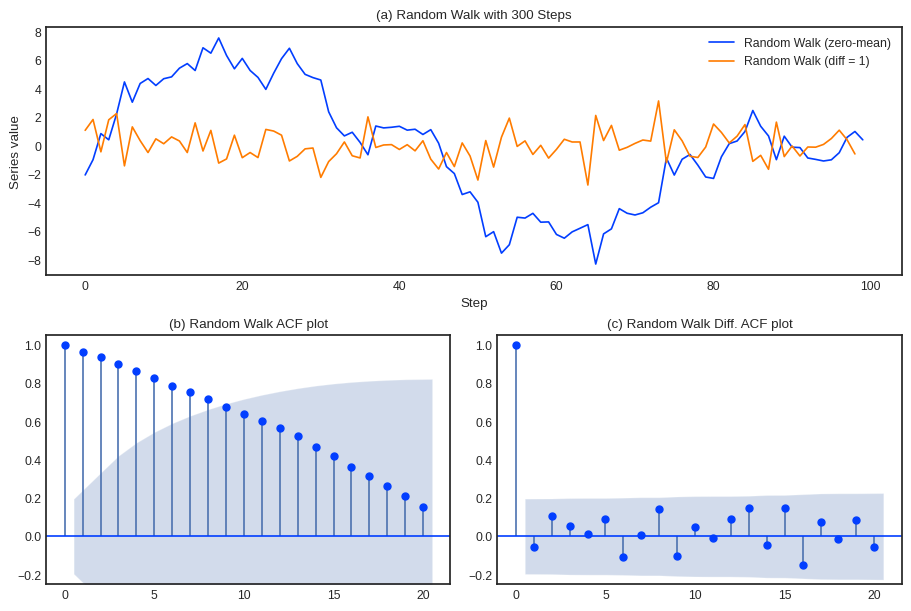

In [4]:
from statsmodels.graphics.tsaplots import plot_acf



fig = plt.figure(figsize = FIG_SIZE_2ROWS, constrained_layout=True)
gs = fig.add_gridspec(2, 2)
fig_ax0 = fig.add_subplot(gs[0, :])
fig_ax1 = fig.add_subplot(gs[1, 0])
fig_ax2 = fig.add_subplot(gs[1, 1])

sns.lineplot(random_walk, label='Random Walk (zero-mean)', color = color_list[0], ax = fig_ax0)
sns.lineplot(random_walk_diff, label='Random Walk (diff = 1)', color = color_list[1], ax = fig_ax0)
fig_ax0.set_xlabel('Step')
fig_ax0.set_ylabel('Series value')
fig_ax0.set_title('(a) Random Walk with 300 Steps')

#plt.show()
#ax = plt.subplot(1,2,1)
plot_acf(random_walk, lags=20, alpha=0.05, title = '(b) Random Walk ACF plot', ax = fig_ax1, color = color_list[0])
fig_ax1.set_ylim((-0.25,1.05))


#ax = plt.subplot(1,2,2)
plot_acf(random_walk_diff, lags=20, alpha=0.05, title = '(c) Random Walk Diff. ACF plot', ax = fig_ax2, color = color_list[0])
fig_ax2.set_ylim((-0.25,1.05))

plt.show()

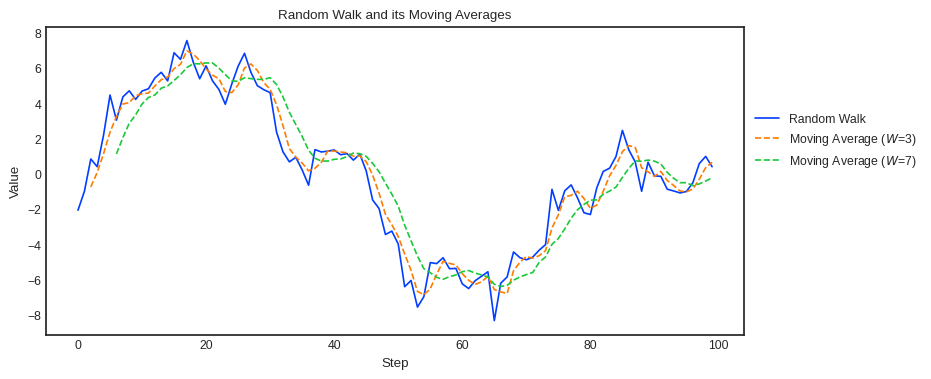

In [5]:
import pandas as pd

plt.plot(random_walk, label='Random Walk', color = color_list[0])

for i,window_size in enumerate([3,7]):
    moving_average = pd.Series(random_walk).rolling(window=window_size, center = False).mean()

    # Plotting the results for visualization
    plt.plot(moving_average, label=f'Moving Average ($W$={window_size})', color=color_list[i+1], linestyle='--')

    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.title('Random Walk and its Moving Averages')

plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


# Step 2: Fit ARIMA model
model = sm.tsa.ARIMA(random_walk[:-FORECAST_STEPS], order=(1, 1, 1))
results = model.fit()

print(results.summary())

# Step 3: Plot diagnostics


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -99.067
Date:                Fri, 07 Jun 2024   AIC                            204.134
Time:                        20:38:20   BIC                            211.242
Sample:                             0   HQIC                           206.982
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1174      0.618      0.190      0.849      -1.094       1.328
ma.L1         -0.2876      0.576     -0.499      0.618      -1.417       0.842
sigma2         0.7187      0.127      5.667      0.0

In [172]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


# Step 2: Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
random_walk_normalized = scaler.fit_transform(random_walk.reshape(-1, 1))

def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
train_size = 80
train, test = random_walk_normalized[0:train_size], random_walk_normalized[train_size:N]
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Step 3: Define and train the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=0)

# Step 4: Use the trained model to predict 20 steps ahead
def predict_future(model, data, steps):
    predictions = []
    current_input = data[-1].reshape(1, 1, look_back)

    for _ in range(steps):
        next_pred = model.predict(current_input)
        predictions.append(next_pred[0, 0])
        current_input = np.append(current_input[:, :, 1:], next_pred).reshape(1, 1, look_back)

    return np.array(predictions)

future_steps = 20
lstm_forecast = predict_future(model, X_test, future_steps)

lstm_forecast = scaler.inverse_transform(lstm_forecast.reshape(-1, 1))

# Step 5: Plot the results
# plt.plot(random_walk, label='Original Random Walk')
# plt.plot(np.arange(len(random_walk), len(random_walk) + future_steps), future_predictions, label='Future Prediction', color='orange')
# plt.xlabel('Step')
# plt.ylabel('Value')
# plt.title('Random Walk with LSTM Future Predictions')
# plt.legend()
# plt.show()


1/1 [==============================] - 0s 30ms/step


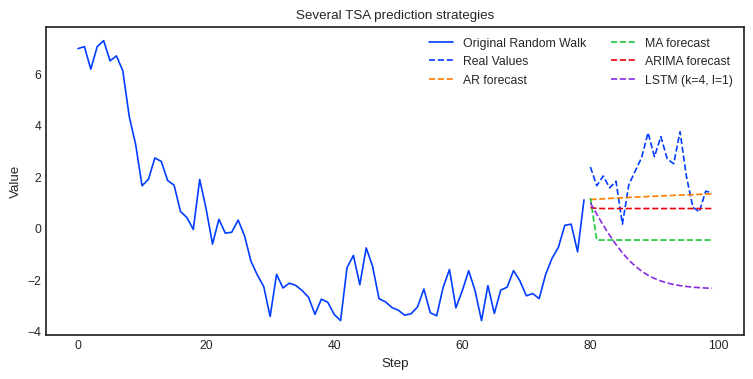

In [175]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st


ar_model = sm.tsa.ARIMA(random_walk[:-FORECAST_STEPS], order=(1, 0, 0))
ma_model = sm.tsa.ARIMA(random_walk[:-FORECAST_STEPS], order=(0, 0, 1))
arima_model = sm.tsa.ARIMA(random_walk[:-FORECAST_STEPS], order=(1, 1, 1))

labels = ['AR forecast', 'MA forecast', 'ARIMA forecast']

# Step 5: Plotting the results
# Generate forecast index for plotting
forecast_index = np.arange(len(random_walk), len(random_walk) + FORECAST_STEPS)

plt.plot(random_walk[:-FORECAST_STEPS], label='Original Random Walk',color= color_list[0])
plt.plot(range(NUM_STEPS-FORECAST_STEPS, NUM_STEPS),random_walk[-FORECAST_STEPS:], label='Real Values',color= color_list[0], linestyle = '--')

for i,model in enumerate([ar_model, ma_model, arima_model]):
    results = model.fit()
    forecast_values = results.forecast(steps=FORECAST_STEPS)

    # Step 4: Compute confidence intervals manually
    stderr = results.bse

    # Compute the z-value for the 95% confidence interval
    z_value = st.norm.ppf(0.975)

    # Compute the confidence intervals
    conf_int = []
    for forecast in forecast_values:
        ci_lower = forecast - z_value * stderr
        ci_upper = forecast + z_value * stderr
        conf_int.append((ci_lower[0], ci_upper[0]))

    conf_int = np.array(conf_int)

    plt.plot(forecast_index - FORECAST_STEPS, forecast_values, label=labels[i], color= color_list[1+i], linestyle = '--')
    #plt.fill_between(forecast_index - FORECAST_STEPS, conf_int[:, 0], conf_int[:, 1], color=color_list[1+i], alpha=0.1)

plt.plot(forecast_index - FORECAST_STEPS, lstm_forecast, label='LSTM (k=4, l=1)', color= color_list[2+i], linestyle = '--')


plt.xlabel('Step')
plt.ylabel('Value')
plt.title('Several TSA prediction strategies')
plt.legend(ncol=2)
plt.show()


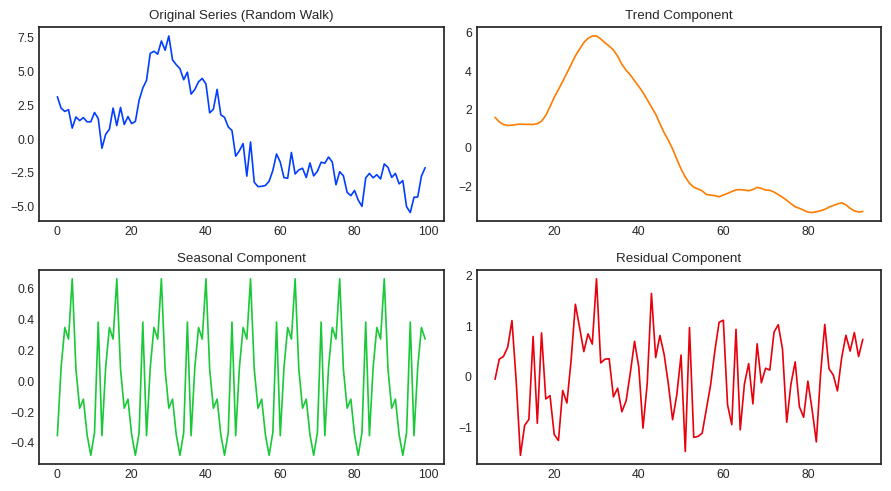

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Step 2: Perform STL decomposition
stl = sm.tsa.seasonal_decompose(random_walk, period=12, model='additive')
trend = stl.trend
seasonal = stl.seasonal
residual = stl.resid

# Step 3: Plot the decomposition
plt.figure(figsize=(9,5))

plt.subplot(2, 2, 1)
plt.plot(random_walk, color = color_list[0])
plt.title('Original Series (Random Walk)')

plt.subplot(2, 2, 2)
plt.plot(trend, color = color_list[1])
plt.title('Trend Component')

plt.subplot(2, 2, 3)
plt.plot(seasonal, color = color_list[2])
plt.title('Seasonal Component')

plt.subplot(2, 2, 4)
plt.plot(residual, color = color_list[3])
plt.title('Residual Component')

plt.tight_layout()
plt.show()
